In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml("mnist_784" ,version=1)

In [3]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [4]:
mnist.data.shape # features

(70000, 784)

In [5]:
mnist.target.shape # target

(70000,)

In [6]:
mnist.frame.shape # combined

(70000, 785)

In [7]:
X = mnist["data"]
y = mnist["target"]

### Basis EDA

In [8]:
sample_digit = X.iloc[11]

In [9]:
sample_image = sample_digit.values.reshape(28, 28)

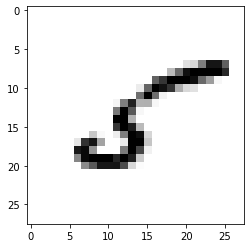

In [10]:
plt.imshow(sample_image, cmap="binary")
# plt.axis("off")
plt.show()

In [11]:
sample_label = y[11]
sample_label

'5'

In [12]:
y = y.astype(np.uint8) # converting string labels to integers

In [13]:
X_train, X_test, y_train, y_test = X.iloc[:60000], X.iloc[60000:], y.iloc[:60000], y.iloc[60000:]

### Implementing binary classifier

In [14]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [15]:
from sklearn.linear_model import SGDClassifier 

sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

##### Note:
    - SGDclassifier relies on randomness during training. So to get reproducible results set random_state to 42

In [16]:
sgd_clf.predict([sample_digit])

D:\programs\TheCompleteML\env\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([ True])

#### Performance measures

In [17]:
"""Occasionally you will need more control over the cross-validation 
process than what Scikit-Learn provides off the shelf. 
In these cases, you can implement cross-validation yourself. 
The following code does roughly the same thing as Scikit-Learn’s 
cross_val_score() function, and it prints the same result:"""


from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

sk_fold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for train_index, test_index in sk_fold.split(X_train, y_train_5):
    X_train_fold = X_train.iloc[train_index]
    y_train_fold = y_train_5.iloc[train_index]
    X_test_fold = X_train.iloc[test_index]
    y_test_fold = y_train_5.iloc[test_index]
    
    clone_clf = clone(sgd_clf)
    clone_clf.fit(X_train_fold, y_train_fold)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct/len(y_pred))

0.9669
0.91625
0.96785


In [29]:
# replication of above method with the coss-validation score
from sklearn.model_selection import cross_val_score

clone_clf = clone(sgd_clf)
cross_val_score(clone_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

##### Observations 
    - Here accuracy is about 92% and also higher than it. But unfortunately it is due to more skewed datasets. It hase 90% false(not five) and 10% true(five) values.
    - So accuracy is not preferred performance measure for classifiers specially when we have skewed datasets

#### Confusion Matrix

In [19]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [20]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

##### Observations
    - True Negative: 53892
    - False Positive: 687
    - False Negative: 1891
    - True Positive: 3530
    
    Precision: 
        - measure of accuracy of postive predictions 
        - Equation: TP/TP + FP
    Recall: 
        - measurre of positive instances that are correcly classified
        - Equation: TP/TP + FN

#### Precision and Recall

In [21]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [22]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

##### Observations
    - when it claims an image represents a 5, it is coorect only 83.71% of time and it detects 65.12% of the 5s

#### F1 score

In [23]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

##### Notes
    - The F1 score is hamrmonic mean of precision and recall. Regular mean treats all the values equally, the harmonis mean gives much more weight to low values. As a result, the classifier only get a high F1 score if both recall and precision are high

#### To get classifier score 

In [24]:
y_scores = sgd_clf.decision_function([sample_digit])

D:\programs\TheCompleteML\env\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


In [25]:
y_scores

array([4742.52813158])

In [26]:
threshold =  0
(y_scores>threshold)

array([ True])

In [27]:
threshold =  8000
(y_scores>threshold)

array([False])

##### Observations
    - as we increase the threshold recall score will decrease and precision score increases, and vice versa

#### Deciding the threshold?

In [28]:
clone_clf = clone(sgd_clf)

In [30]:
y_scores = cross_val_predict(clone_clf, X_train, y_train_5, cv=3, method="decision_function")

In [31]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [32]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.legend(("Precision", "Recall"))
    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.grid()
    plt.show()

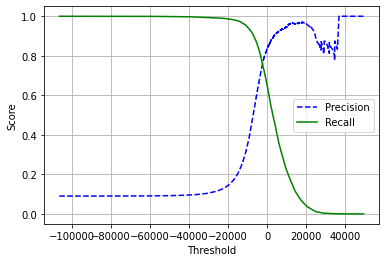

In [33]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

In [34]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions)
    plt.xlabel("Recalls")
    plt.ylabel("Precisions")
    plt.grid()
    plt.show()

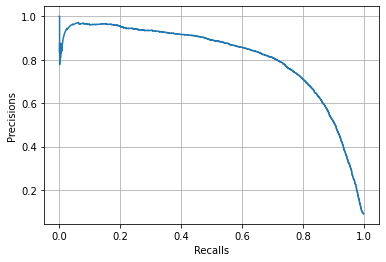

In [35]:
plot_precision_vs_recall(precisions, recalls)

#### To get 90% precision values
    - first we need to get the value of thresholds where precision is just crossing above 90%
    - prediction should be done based on that threshold value rathre then predict method

In [36]:
threshold_90_precision = thresholds[np.argmax(precisions>=0.90)]

In [37]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [38]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [39]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

##### Observations
    - Thus like this we can get whatever precision and recall score.
    - but high precision model with recall is too low can't be used much
    
    Note:
        - If someone says, “Let’s reach 99% precision,” you should ask, “At what recall?”

#### ROC(Receiver operating characteristic) Curve
    - ROC curve the TPR(True positive rate) againts the FPR(False positive rate)
    - FPR is the ratio negative instances that are incorrectly classified
    - Equation: FPR = 1 - TNR
    - TNR is ratio of negative instances that are correctly classsified. Which is also known as specificity
    - Hence ROC curve plots sensitivity vs 1 - specificity 

In [40]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [53]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], "k--")
    plt.title(label)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Negative Rate")
    plt.grid()
    plt.show()

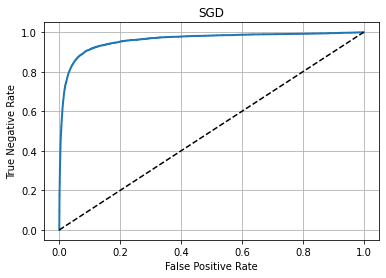

In [55]:
plot_roc_curve(fpr, tpr, label="SGD")

##### Observations
    - Again trade-off here, the higher the TPR lower the FPR
    - The dotted line here represents the ROC curve of purely random cladssifier, a good classifier stays as far away from that line
    
##### Note:
        - One way to compare the classifier is to measure the area under the curve(AUC).
        - Perfect classifier will have a ROC AUC 1, where as random classfier will have ROC AUC value 0.5

In [43]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

##### Note
    - As a rule of thumb, one should prefer the PR curve whenever the positive class is rare or when one care more about the
    false positives then the false negatives. Otherwise use the ROC curve.

### Using RandomForestClassfier
    -RandomForestClassifier do not have decision_function method because the way it works. Instead, it has predict_proba method. Sklearn classifier do have either of one or both methods.
    - The predict_proba() method returns an array containing a row per instance and a column per class, each containing the probability that the given instance belongs to the given class

In [44]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(rf_clf, X_train, y_train_5, method="predict_proba")

In [47]:
y_probas_forest

array([[0.14, 0.86],
       [0.99, 0.01],
       [0.98, 0.02],
       ...,
       [0.01, 0.99],
       [0.96, 0.04],
       [0.96, 0.04]])

In [49]:
y_test_5.iloc[0]

False

##### Note
    - Let's take the positive class's probabalities as a score for ROC curve

#### ROC curve

In [51]:
y_scores_forest = y_probas_forest[:, 1]

In [52]:
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

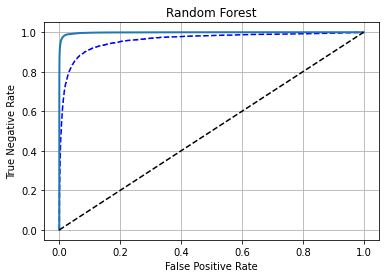

In [57]:
plt.plot(fpr, tpr, "b--", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")

In [58]:
roc_auc_score(y_train_5, y_scores_forest)

0.998402186461512

##### Observations
    - ROC is much closer to left corner so subsequently ROC AUC also quite high

#### PR Curve

In [59]:
pr_forest, re_forest, th_forest = precision_recall_curve(y_train_5, y_scores_forest)

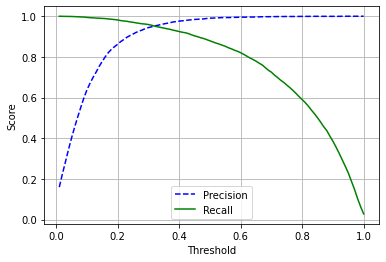

In [61]:
plot_precision_recall_vs_threshold(pr_forest, re_forest, th_forest)

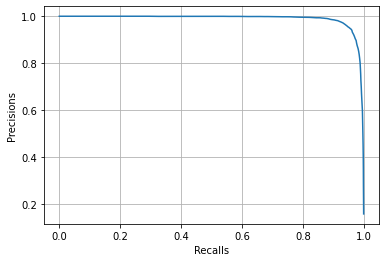

In [62]:
plot_precision_vs_recall(pr_forest, re_forest)

In [88]:
y_train_predi_forest_60 = (y_probas_forest[:, 1]>=0.60)

In [89]:
precision_score(y_train_5, y_train_predi_forest_60)

0.9953020134228188

In [90]:
recall_score(y_train_5, y_train_predi_forest_60)

0.8206972883231876

##### Observations
    - By changing the probabality thresholds we can extend the values for precision and recall score

#### Confusion Matrix

In [91]:
confusion_matrix(y_train_5, y_train_predi_forest_60)

array([[54558,    21],
       [  972,  4449]], dtype=int64)

In [2]:
import numpy as np
np.array((3, 10, 12))

array([ 3, 10, 12])

In [7]:
test = np.empty([3, 2, 2])
test

array([[[6.23042070e-307, 4.45046008e-307],
        [1.37959129e-306, 9.34604358e-307]],

       [[3.11523412e-307, 1.95821439e-306],
        [8.01097889e-307, 1.78020169e-306]],

       [[7.56601165e-307, 1.02359984e-306],
        [3.72364481e-317, 1.39067116e-308]]])

In [8]:
test.reshape(3, 4)

array([[6.23042070e-307, 4.45046008e-307, 1.37959129e-306,
        9.34604358e-307],
       [3.11523412e-307, 1.95821439e-306, 8.01097889e-307,
        1.78020169e-306],
       [7.56601165e-307, 1.02359984e-306, 3.72364481e-317,
        1.39067116e-308]])